In [98]:
import numpy as np                                     
import matplotlib.pyplot as plt                      
import seaborn as sns                                
from iminuit import Minuit                      
import sys             
from sympy import *                           
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
from scipy.special import expit
import pandas as pd
import os
from importlib import reload

plt.style.use("../KD_style.mplstyle")

In [99]:
data = pd.read_csv("./FranksNumbers.txt", sep = "\s+", names = ["x", "y", "delete"], skiprows=1)
data = data.drop("delete", axis = 1)
# digit_mask = np.array([row.isdigit() for row in data["x"]])
false_indices = np.array([idx for idx, row in enumerate(data["x"]) if not row.isdigit()])
# print(false_indices)
data_dict = {}
for idx, dataset in enumerate(np.split(data.to_numpy(), false_indices)):
    data_dict[idx] = pd.DataFrame(dataset[1:], columns = data.keys(), dtype=np.float64)

del data_dict[0]


,x_mean,x_var,y_mean,y_var
0,9.0,11.000000,7.500909,4.127269
1,9.0,11.000000,7.500909,4.127629
2,9.0,11.000000,7.500000,4.122620
3,9.0,11.000000,7.500909,4.123249
4,9.0,10.232558,7.500682,3.837388


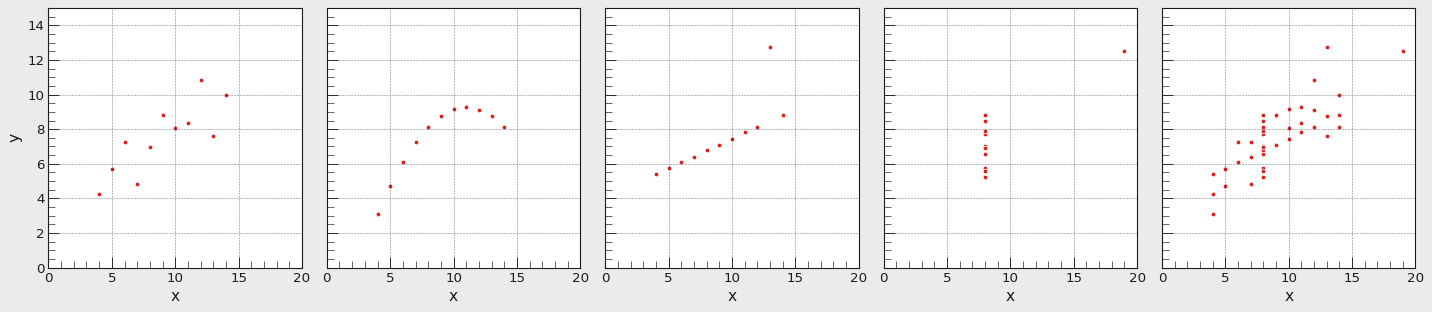

In [100]:
fig, axes = plt.subplots(1, 5, figsize = (18,4), sharey = True)
data_info = np.zeros((len(data_dict.keys()), 4)) # data is setup to be x_mean, x_variance, y_mean, y_variacne 
for idx, (dataset, ax) in enumerate(zip(data_dict.values(), axes)):
    sns.scatterplot(x = 'x', y = 'y', data = dataset, ax = ax, s = 70)
    data_info[idx] = [np.mean(dataset["x"]), np.var(dataset["x"], ddof=1), np.mean(dataset["y"]), np.var(dataset["y"], ddof = 1)]
    ax.set_xlim(0,20)
    ax.set_ylim(0,15)
data_info_df = pd.DataFrame(data_info, columns=["x_mean", "x_var", "y_mean", "y_var"])
display(data_info_df)
plt.tight_layout()

In [101]:
# add errors to datasets:
for idx, (dataset, key) in enumerate(zip(data_dict.values(), data_dict.keys())):
    sqrt_err = np.sqrt(dataset["y"].to_numpy())
    fix_err = [1.22 for row in dataset["x"]]
    error_df = pd.DataFrame(np.array([sqrt_err, fix_err]).T, columns = ["sqrt_err", "fixed_err"])
    data_dict[key] = pd.concat([dataset, error_df], axis = 1)

In [102]:
def try_func(x):
    return 0.48*x + 3.02

def chi2(func, x, y, y_err):
    return np.sum((y - func(x))**2/y_err**2)

chi2_matrix = np.zeros([len(data_dict.keys()), 2])

for idx, dataset in enumerate(data_dict.values()):
    chi2_sqrt = chi2(try_func, dataset["x"], dataset["y"], dataset["sqrt_err"])
    chi2_fixed = chi2(try_func, dataset["x"], dataset["y"], dataset["fixed_err"])
    chi2_matrix[idx] = [chi2_sqrt, chi2_fixed]
chi2_df = pd.DataFrame(chi2_matrix, columns = ["chi2_sqrt_err","chi2_fixed_err"])
data_info_df = pd.concat([data_info_df, chi2_df], axis = 1)

In [103]:
display(data_info_df)

,x_mean,x_var,y_mean,y_var,chi2_sqrt_err,chi2_fixed_err
0,9.0,11.000000,7.500909,4.127269,1.894609,9.467818
1,9.0,11.000000,7.500909,4.127629,2.405990,9.476686
2,9.0,11.000000,7.500000,4.122620,1.207580,9.460226
3,9.0,11.000000,7.500909,4.123249,2.017383,9.453709
4,9.0,10.232558,7.500682,3.837388,7.525561,37.858439
